"""
Shape Detection on Neural Spikes
==================================
Detecting shapes in a 1D signal using log-cost ratio based on the Euclidean distance measure. 


Note: 
The implementation in this template is intended for teaching purposes only and is not 
optimised for efficiency. For a computationally efficient implementation, for loops should
be avoided.
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
FILENAME = "./csv/pulsed-signals-01-no-artifact.csv"
SLICE_WIDTH = 50 # spike with; length of a single spike
SAVE_FIGURE = True # True: saves figure as a .PNG file (for documentation)

In [3]:
def load_CSV(filename):
    """
    Loads a single signal from the CSV file named filename. 

    Expected CSV File Format: 
    - Column 0: Sample Index k (int)
    - Column 1: Sample Value y_k (float)
    - Column 2: Sample index of spike beginning (0: no spike, 1: first sample of a new spike)
    - Column 3: Source neuron cluster 1,2,3,... (int)
  
    Parameters
    ----------
    filename : string
               CSV filename e.g. "data.csv"
               
    Returns
    -------
    y  : numpy.ndarray of floats of shape (K,)
         Loaded sample data
    is_spike: numpy.ndarray of bool of shape (K,)
         indicates if a spike starts at this time index. "True" or "False". 
    neuron_source: numpy.ndarray of float (K,)
         indicates neuron source clustr 1,2,3,... for each time index (=Ground Truth). 0 for no neuron. 

    with
    NOF_SPIKES: number of pulses
    K: number of samples in the observed signal y. 
    """
    ys_csv = np.loadtxt(FILENAME, delimiter=',') # load CSV
    index_k = ys_csv[:,0] # extract sample indices
    y = ys_csv[:,1] # extract signal samples y
    is_spike = (ys_csv[:,2]>0) # True for spike start at this index; False otherwise
    neuron_source = ys_csv[:,3].astype(int) # source neuron index 1, 2, 3, ...
    return (index_k, y, is_spike, neuron_source)

def extract_slices(y, k0s, SLICE_WIDTH):
    """
    Extracts signal slices form signal y, starting at indices k0s and each slice is of length SLICE_WIDTH
    
    Parameters
    ----------
    y   : array_like of floats of shape=(K)
          observed signal of length K
    k0s : list of ints length NOF_SLICES 
          list with start indices of each slice
    SLICE_WIDTH : int
        length of a single slices

    Returns
    -------
    s  : numpy.ndarray of shape=shape of (NOF_SLICES, SLICE_WIDTH) of floats`
         each row contains the samples of a single slice, i.e. of a single neural spike
  
    with

    NOF_SPIKES: number of slices
    SLICE_WIDTH: slice length 
    K: number of samples in the observed signal y.  
    """ 
    
    NOF_SLICES = len(k0s) # number of spikes
    LEN_Y = len(y)
    z_slices = np.zeros( (NOF_SLICES, SLICE_WIDTH) ) # memory for spikes
    for p in range(NOF_SLICES): # cut out each slice (=neural spike)
       if (k0s[p]+SLICE_WIDTH >= LEN_Y): # prevents accessing array indices out of range
           continue
       z_slices[p, :] = y[k0s[p]:k0s[p]+SLICE_WIDTH] # cuts out a single slice
    return (z_slices)

We observe the arbitrary electrical activity of three neurone 1, 2, and 3 in a so-called
spike train, as shown in Figure 1 above. Spike trains are recorded with micro electrodes
placed on the cortex. It is known that spikes generated by every neurone have their own
characteristic shape. In the figure above, for example, the first and the second spike seem
to originate from the same neurone, while the third and the fourth spike originate from a
different neurone.
In the following exercises, we are interested in localizing and identifying all activities of
neurone 1, which is known to be the source of the first spike in the recording (marked by
▲ in the figure).

The CSV files have the following four data columns:
* – Column 1: sample index (int)
* – Column 2: signal sample value (float)
* – Column 3: binary flag indicating start indexes of new spikes: "1" if a new spike
starts at this sample index, 0 otherwise (Bool)
* – Column 4: Source Neuron 1, 2, or 3 (Ground Truth, to verify your results)
(Int)

For example the first lines of pulsed-signals-01-no-artifact.csv with the four
data columns are:
* 0.000000,0.008820,0.000000,0.000000
* 1.000000,0.002001,0.000000,0.000000
* 2.000000,0.004894,0.000000,0.000000
....

# Exercise 4-1: Spike Detection

In [4]:
# Loading CSV File
(index_k, y, is_pulse, neuron_sources) = load_CSV(filename = FILENAME)
K = y.shape[0] # total number of samples
k = np.arange(K)
REF_INDEX =  np.where(is_pulse!=False)[0][0] # find time index of first spike which is the reference spike
zs = extract_slices(y, k, SLICE_WIDTH) # Slices the signal. The slices are stored as rows in matrix zs.
print("REF_INDEX: " + str(REF_INDEX))
print(zs)

REF_INDEX: 20
[[0.00882  0.002001 0.004894 ... 0.027416 0.025948 0.043846]
 [0.002001 0.004894 0.011204 ... 0.025948 0.043846 0.051555]
 [0.004894 0.011204 0.009338 ... 0.043846 0.051555 0.069123]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]]


In [22]:
# Reference slice
z0 = zs[REF_INDEX]

# Distance measure per spike (dummy code), Calculate for each k the squared distance ∥zk − z0 ∥2 (to be stored in distances_sq)
distances_sq = np.ones(K);
for i, zk in enumerate(zs):
    distances_sq[i] = np.sum((zk - z0) ** 2)
print("Distance SQ:")
print(distances_sq)

# Energy per spike (dummy code), Calculate for each k the energy of the slices ∥zk ∥2 (to be stored in shape_energy).
shape_energy = np.ones(K)
for i, zk in enumerate(zs):
    shape_energy[i] = np.sum(zk ** 2)
print("Shape Energy:")
print(shape_energy)


# Local Contrast Ratio (LCR) calculation
lcr = np.ones(K)
for i, zk in enumerate(zs):
    if shape_energy[i] != 0 and distances_sq[i] != 0:
        ratio = distances_sq[i] / shape_energy[i]
        lcr[i] = -0.5 * np.log(ratio)
    else:
        lcr[i] = 0  # Handle cases where energy is zero  
print("LCR:")
print(lcr)

# max. LCR value for detection (manually tuned), Define an LCR peak threshold (use variable LCR_THRESHOLD ) and apply a peak finder on the LCR to find the spike positions.
LCR_THRESHOLD = 1.5
indices_spikes_detected, _ = find_peaks(lcr, height=LCR_THRESHOLD)

Distance SQ:
[0.32342918 0.31325141 0.30221509 ... 0.20500281 0.20500281 0.20500281]
Shape Energy:
[0.02285161 0.02543173 0.03020572 ... 0.         0.         0.        ]
LCR:
[-1.32497939 -1.25550421 -1.15155389 ...  0.          0.
  0.        ]


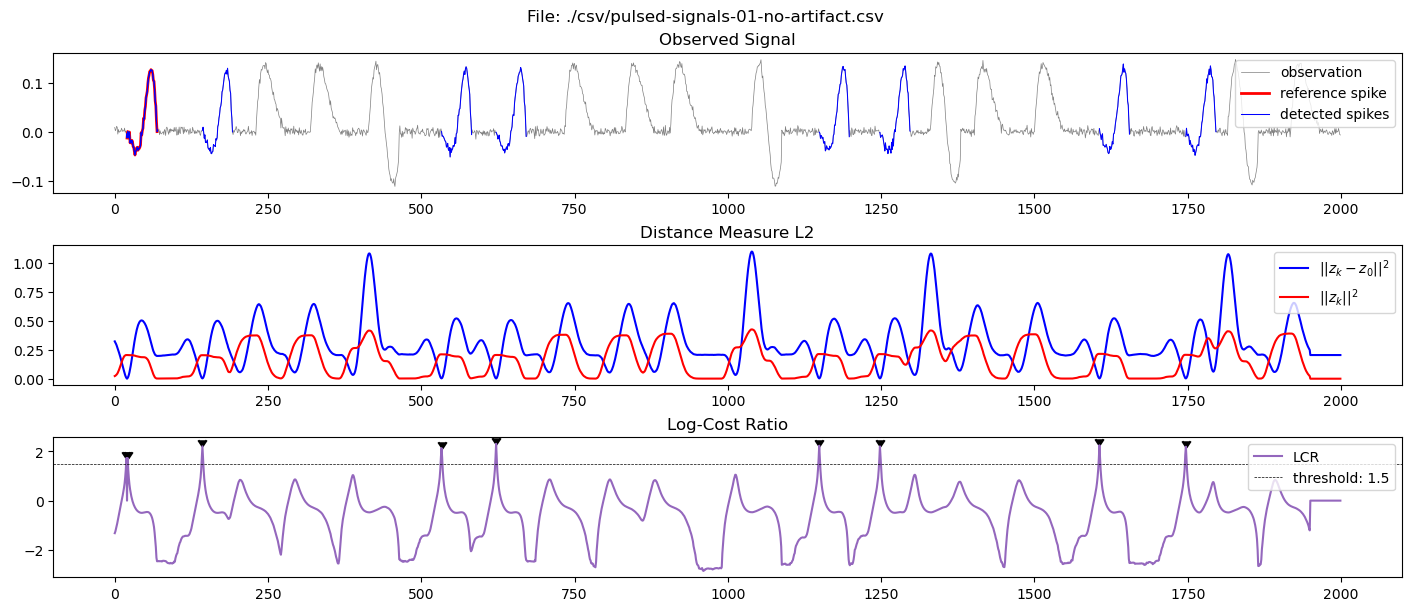

In [23]:
# ========= PLOTTING of RESULTS =============================================
fig = plt.figure(figsize=(14,6), constrained_layout=True)
spec = fig.add_gridspec(3, 1)
ax0 = fig.add_subplot(spec[0, :])
ax1 = fig.add_subplot(spec[1, :], sharex=ax0)
ax2 = fig.add_subplot(spec[2, :], sharex=ax0)

plt.suptitle("File: "+FILENAME)

# -- Subplot 0 : plot signal with reference pulse and detected pulses --
ax0.set_title("Observed Signal")
ax0.plot(range(K), y, lw=0.5, c='tab:gray') # observation
k_ref = k[REF_INDEX]
ax0.plot(range(SLICE_WIDTH)+k_ref, y[range(SLICE_WIDTH)+k_ref], lw=2.0, c='r') # reference spike 
for k0 in indices_spikes_detected: # draw projected polynomials
    lastline, = ax0.plot(range(SLICE_WIDTH)+k0, y[range(SLICE_WIDTH)+k0], lw=.75, c='b') # detected spikes
ax0.legend(["observation","reference spike","detected spikes"], loc="upper right")

# -- Subplot 1 : plot distance measures  --
ax1.set(title="Distance Measure L2")
ax1.plot(k, distances_sq, 'b', label="$||z_k-z_0||^2$")
ax1.plot(k, shape_energy, 'r', label="$||z_k||^2$")
ax1.legend(loc="upper right")

# -- Subplot 2 : plot LCR with threshold (dashed line) --
ax2.set(title="Log-Cost Ratio")
ax2.plot(k, lcr, color="tab:purple", label="LCR")
ax2.axhline(y = LCR_THRESHOLD, ls='--', lw=0.5, c='k', label="threshold: "+str(LCR_THRESHOLD))
ax2.scatter(indices_spikes_detected, lcr[indices_spikes_detected], marker=7, c='k') # peak markers
ax2.legend(loc="upper right")

plt.show()

# ------- SAVING figure for documentation ------ 
if SAVE_FIGURE: # save example
    fig.savefig("./figs-out/solution-detection.png")

In [27]:
# Evaluate performance
# Ground truth spike indices (where is_spike is True)
indices_spikes_csv = index_k[is_pulse].astype(int)
true_positives = np.intersect1d(indices_spikes_detected, indices_spikes_csv)
false_positives = np.setdiff1d(indices_spikes_detected, indices_spikes_csv)
false_negatives = np.setdiff1d(indices_spikes_csv, indices_spikes_detected)


# Print results
print("Indices of spikes detected (from the algorithm):")
print(indices_spikes_detected)

print("\nIndices of spikes in the CSV (ground truth):")
print(indices_spikes_csv)

print("\nTrue positives (correctly detected spikes):")
print(true_positives)

print("\nFalse positives (wrongly detected as spikes):")
print(false_positives)

print("\nFalse negatives (missed spikes):")
print(false_negatives)

print("\nValues at false negatives (actual positions in the signal):")
print(index_k[false_negatives])

Indices of spikes detected (from the algorithm):
[  19   21  143  533  622 1149 1248 1606 1747]

Indices of spikes in the CSV (ground truth):
[  20  143  230  319  414  533  622  734  833  906 1038 1149 1248 1330
 1402 1500 1606 1747 1815 1918]

True positives (correctly detected spikes):
[ 143  533  622 1149 1248 1606 1747]

False positives (wrongly detected as spikes):
[19 21]

False negatives (missed spikes):
[  20  230  319  414  734  833  906 1038 1330 1402 1500 1815 1918]

Values at false negatives (actual positions in the signal):
[  20.  230.  319.  414.  734.  833.  906. 1038. 1330. 1402. 1500. 1815.
 1918.]
